# **Google Stock Price Prediction using LSTM RNN's.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['trainset.csv', 'testset.csv']


In [2]:
def modifyDataset(data):
    trainset = data.iloc[:,1:2].values
    return trainset

# **Loading the Training Dataset and Scaling the Feature Values in the Range of 0 to 1.**

In [3]:
dataset_train = pd.read_csv("../input/trainset.csv")
trainset = modifyDataset(dataset_train)
trainset

array([[ 357.385559],
       [ 360.122742],
       [ 362.313507],
       ...,
       [1057.390015],
       [1051.599976],
       [1046.719971]])

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(trainset)
len(training_scaled)

1259

# **Creating Subsequences of the Data**
These subsequences are of length 60 and coded in such a way that the first 59 values are used as input to the Neural Network and the Last value is used as the label to be predicted.

In [5]:
x_train = []
y_train = []
n_len = 60
for i in range(n_len,len(training_scaled)):
    x_train.append(training_scaled[i-n_len:i, 0])
    y_train.append(training_scaled[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

In [6]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Bidirectional
from keras.layers import LSTM, GRU
from keras.layers import Dropout

Using TensorFlow backend.


# **LSTM Model**

LSTMs (“long short-term memory” units) are the most powerful and well known subset of Recurrent neural networks. What differentiates LSTMs from other neural networks is that they take time and sequence into account, they have a temporal dimension hence, these type of artificial neural network are designed to recognize patterns in sequences of data, such as numerical times series data emanating from sensors, stock markets and government agencies (but also including text, genomes, handwriting and the spoken word). (For more information about LSTM's and their inherent characteristics, please visit https://pathmind.com/wiki/lstm)

The code block below shows the LSTM model (named Regressor here) that has been designed to learn the necessary features from the data. The LSTM model used in this model has 4 LSTM layers followed by a Dense Neural Network Architecture. At every step of the LSTM layer, we return the sequences, hence we need to use a flatten layer before we can connect the LSTM layers to the Dense layers. The model used here has approximately 46 Mn parameters and GPU was used to train the model. Loss is measured in terms of the Mean Absolute Error in this case and adam optimizer was used (ADAM Optimizer - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [8]:
regressor = Sequential()
regressor.add(LSTM(units = 1000,return_sequences = True,input_shape = (x_train.shape[1],1)))

regressor.add(LSTM(units = 750,return_sequences = True))

regressor.add(LSTM(units = 600,return_sequences = True))

regressor.add(LSTM(units = 500,return_sequences = True))

regressor.add(Flatten())

regressor.add(Dense(units = 1024, activation = 'relu'))
regressor.add(Dropout(0.25))

regressor.add(Dense(units = 256, activation = 'relu'))
regressor.add(Dropout(0.15))

regressor.add(Dense(units = 32, activation = 'relu'))
regressor.add(Dropout(0.05))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam',loss = 'mean_absolute_error')

regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 1000)          4008000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 750)           5253000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 600)           3242400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 500)           2202000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              30721024  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________

In [78]:
regressor.fit(x_train,y_train,epochs = 5, batch_size = 64)

Epoch 1/5
1199/1199 [==============================] - 17s 14ms/step - loss: 0.0285
Epoch 2/5
1199/1199 [==============================] - 8s 7ms/step - loss: 0.0253
Epoch 3/5
1199/1199 [==============================] - 8s 7ms/step - loss: 0.0244
Epoch 4/5
1199/1199 [==============================] - 8s 7ms/step - loss: 0.0248
Epoch 5/5
1199/1199 [==============================] - 8s 6ms/step - loss: 0.0279


The weights of the trained model are stored in a separate hdf5 format. This ensures that the weights from the trained model can be used without having to training the model whenever we want to make a prediction.

In [79]:
regressor.save_weights('model.hdf5')

In [80]:
regressor.compile(optimizer = 'adam',loss = 'mean_absolute_error')
regressor.load_weights('/kaggle/working/model.hdf5')


# **Preprocessing the Test Dataset**

In [81]:
dataset_test =pd.read_csv("../input/testset.csv")
real_stock_price = dataset_test.iloc[:,1:2].values

dataset_total = pd.concat((dataset_train['Open'],dataset_test['Open']),axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test)-n_len:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs.shape

(185, 1)

In [82]:
x_test = []
for i in range(n_len,inputs.shape[0]):
    x_test.append(inputs[i-n_len:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(125, 60, 1)

# **Predicting the Stock Prices using the LSTM Model and Visualization**

In [83]:
predicted_price = regressor.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)
predicted_price

array([[1036.0966 ],
       [1040.3715 ],
       [1053.5265 ],
       [1078.6337 ],
       [1079.4694 ],
       [1084.0027 ],
       [1094.2982 ],
       [1086.7975 ],
       [1095.6788 ],
       [1094.925  ],
       [1117.933  ],
       [1108.2926 ],
       [1116.482  ],
       [1109.0948 ],
       [1115.348  ],
       [1142.7917 ],
       [1159.8829 ],
       [1149.5317 ],
       [1149.825  ],
       [1156.8031 ],
       [1150.0382 ],
       [1156.6531 ],
       [1152.9454 ],
       [1114.184  ],
       [1088.3087 ],
       [1031.4362 ],
       [1095.0947 ],
       [1066.5831 ],
       [1027.6594 ],
       [1051.5376 ],
       [1041.2535 ],
       [1045.9066 ],
       [1072.7577 ],
       [1076.5536 ],
       [1070.5653 ],
       [1097.0369 ],
       [1098.1482 ],
       [1092.7695 ],
       [1111.3402 ],
       [1122.1096 ],
       [1102.023  ],
       [1086.0194 ],
       [1039.2711 ],
       [1058.4432 ],
       [1091.8195 ],
       [1087.803  ],
       [1094.407  ],
       [1121.

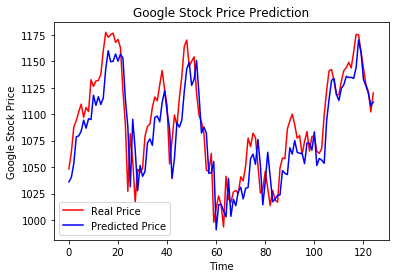

In [84]:
plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()